# LOAD PACKAGES

In [51]:
# Load packages
import numpy as np  
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import tensorflow as tf
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
print "Read in packages from numpy, pandas, sklearn, seaborn & matplotlib"

Read in packages from numpy, pandas, sklearn, seaborn & matplotlib


# PICKLING

In [2]:
from six.moves import cPickle as pickle
pickle_file = 'train_set.pickle'

## Read from Pickle

In [3]:
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    ptrain_set = save['train_set']
    del save  # hint to help gc free up memory
    print('Loaded ptrain_set', ptrain_set.shape)
    
f.close()

('Loaded ptrain_set', (190080, 18))


# TRAIN / TEST SPLIT

In [79]:
# Split train / test data - for coarse training
# Dropping data from Jan 1 because it is a holiday
train_days     = range(2,16)
train_times    = range(39,140,4)

test_days      = range(16, 22)
test_times     = range(39,140,4)

X_train     = ptrain_set[(ptrain_set['num_day'].isin(train_days))    & (ptrain_set['time_slot'].isin(train_times))]
X_test      = ptrain_set[(ptrain_set['num_day'].isin(test_days))     & (ptrain_set['time_slot'].isin(test_times))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (24024, 18) (10296, 18) 




## SCALING

In [80]:
# Scaling for input features
# Generate scaled features for train, validate & test sets

import warnings
warnings.filterwarnings('ignore')

r_predictors = ['time_slot', 'week_day', 'demand_t-1', 'demand_t-2', 'demand_t-3', 
                'poi_cluster', 'congestion'] 

a_predictors = ['time_slot', 'week_day', 'supply_t-1', 'supply_t-2', 'supply_t-3', 
                'poi_cluster', 'congestion'] 

rX_train = []
ry_train = []
aX_train = []
ay_train = []

rX_validate = []
ry_validate = []
aX_validate = []
ay_validate = []

rX_test = []
ry_test = []
aX_test = []
ay_test = []

# Normalize features - both training & test (withheld & final)
r_scaler = StandardScaler().fit(ptrain_set[r_predictors])
a_scaler = StandardScaler().fit(ptrain_set[a_predictors])

d_scaler = StandardScaler().fit(ptrain_set['demand'])
s_scaler = StandardScaler().fit(ptrain_set['supply'])

# Input Samples and Target Values for Demand(r), Supply(a)
# Demand
rX_train  = r_scaler.transform(X_train[r_predictors])
ry_train  = d_scaler.transform(X_train['demand'])

rX_validate = r_scaler.transform(X_validate[r_predictors])
ry_validate = d_scaler.transform(X_validate['demand'])

rX_test = r_scaler.transform(X_test[r_predictors])
ry_test = d_scaler.transform(X_test['demand'])

# Supply
aX_train = a_scaler.transform(X_train[a_predictors])
ay_train = s_scaler.transform(X_train['supply'])

aX_validate = a_scaler.transform(X_validate[a_predictors])
ay_validate = s_scaler.transform(X_validate['supply'])

aX_test = a_scaler.transform(X_test[a_predictors])
ay_test = s_scaler.transform(X_test['supply'])

## SCORES

In [5]:
# Calculate the MAPE Score
def mape_score(exp, pred):
    mape = 0.0
    n = 66.0
    q = 43.0
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

# Evaluate Scores & Present as a table - Mean Squared, R2, MAPE
def eval_score(y_train, y_pred_train, y_validate, y_pred_validate, y_test, y_pred_test):
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_validate = metrics.mean_squared_error(y_validate, y_pred_validate)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_validate = metrics.r2_score(y_validate, y_pred_validate)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    mpscore_train    = mape_score(y_train,    y_pred_train)
    mpscore_validate = mape_score(y_validate, y_pred_validate)
    mpscore_test     = mape_score(y_test,     y_pred_test)


    sets_list = ["TRAIN", "VALIDATE", "TEST"]

    m2_scores = [m2score_train, m2score_validate, m2score_test]
    r2_scores = [r2score_train, r2score_validate, r2score_test]
    mp_scores = [mpscore_train, mpscore_validate, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'


    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.2f}\t\t{2:.2f}\t\t{3:.2f}' .format(s, m, r, mp)

In [6]:
# Use fit function to generate predictions for train, validate and test sets
# Evaluate scores and print results
# Used for demand, supply predictions
def predict_score(train_set, validate_set, test_set, predictors, exp_col, fitfunc, *fitargs):

    # Generate dataframe for train, validate & test
    Xtrain_df    = train_set[predictors]
    Xvalidate_df = validate_set[predictors]
    Xtest_df     = test_set[predictors]
    
    # Generate predictions for train, validate & test
    y_pred_train    = fitfunc(Xtrain_df,    *fitargs)
    y_pred_validate = fitfunc(Xvalidate_df, *fitargs)
    y_pred_test     = fitfunc(Xtest_df,     *fitargs)

    # Extract expected train, validated & test values
    y_train    = train_set[exp_col]
    y_validate = validate_set[exp_col]
    y_test     = test_set[exp_col]

    # Evaluate scores and print results
    eval_score(y_train, y_pred_train, y_validate, y_pred_validate, y_test, y_pred_test)
    
    return(y_pred_train, y_pred_validate, y_pred_test)

## LEARNING CURVES

In [50]:
# Generates training vs cross-validation curves

print(__doc__)

from sklearn import cross_validation
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Automatically created module for IPython interactive environment


## DEMAND, SUPPLY PREDICTIONS & GAP FORECASTING

In [7]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for demand, supply, gap are in namesake columns
def gap_forecast(**kwargs):
    
    X_train      = kwargs["train_set"]
    X_validate   = kwargs["validate_set"]
    X_test       = kwargs["test_set"]
    r_predictors = kwargs["demand_predictors"]
    a_predictors = kwargs["supply_predictors"]
    r_fitfunc    = kwargs["rfit_func"]
    r_fitargs    = kwargs["rfit_args"]
    a_fitfunc    = kwargs["afit_func"]
    a_fitargs    = kwargs["afit_args"]
    
    print "\n\nDEMAND FORECASTING"
    print     "=================="

    ry_pred_train, ry_pred_validate, ry_pred_test = predict_score(X_train, X_validate, X_test, 
                                                                  r_predictors, 'demand', 
                                                                  r_fitfunc, *r_fitargs)

    print "\n\nSUPPLY FORECASTING"
    print     "=================="

    ay_pred_train, ay_pred_validate, ay_pred_test = predict_score(X_train, X_validate, X_test,
                                                                  a_predictors, 'supply', 
                                                                  a_fitfunc, *a_fitargs)

    print "\n\nGAP FORECASTING"
    print     "==============="

    gapy_pred_train    = [r - a for r, a in zip(ry_pred_train,    ay_pred_train)]
    gapy_pred_validate = [r - a for r, a in zip(ry_pred_validate, ay_pred_validate)]
    gapy_pred_test     = [r - a for r, a in zip(ry_pred_test,     ay_pred_test)]

    gapy_train    = X_train['gap']
    gapy_validate = X_validate['gap']
    gapy_test     = X_test['gap']

    eval_score(gapy_train, gapy_pred_train, gapy_validate, gapy_pred_validate, gapy_test, gapy_pred_test)
    
    return

In [75]:
# Generate learning curves by varying training sizes
# Use Training vs Cross-validation curves
def generate_learningcurves(**kwargs):    
   
    rX_train      = kwargs["rX_train"]
    ry_train      = kwargs["ry_train"]
    aX_train      = kwargs["aX_train"]
    ay_train      = kwargs["ay_train"]
        
    r_alg         = kwargs["r_alg"]
    a_alg         = kwargs["a_alg"]
    alg_name      = kwargs["alg_name"]
          
    # Plot learning curve - Demand
    X, y = rX_train, ry_train

    title = 'Learning Curves for Demand (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)

    estimator = r_alg
    plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.01, 1.0, 20))
    plt.show()
    
    # Plot learning curve - Supply
    X, y = aX_train, ay_train

    title = 'Learning Curves for Supply (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)

    estimator = a_alg
    plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(.01, 1.0, 20))
    plt.show()

In [87]:
# Generate learning curves by varying training sizes
# Use Training vs Cross-validation curves
def generate_traintestscores(**kwargs):    
   
    rX_train      = kwargs["rX_train"]
    ry_train      = kwargs["ry_train"]
    aX_train      = kwargs["aX_train"]
    ay_train      = kwargs["ay_train"]
    
    rX_test       = kwargs["rX_test"]
    ry_test       = kwargs["ry_test"]
    aX_test       = kwargs["aX_test"]
    ay_test       = kwargs["ay_test"]
        
    r_alg         = kwargs["r_alg"]
    a_alg         = kwargs["a_alg"]
    alg_name      = kwargs["alg_name"]
    
    # Create training set of increasing sizes
    train_size_set = [4000, 8000, 12000, 16000, 20000, 24024]

    Xr_train_set = []
    yr_train_set = []
    Xa_train_set = []
    ya_train_set = []
    
    Xr_test = rX_test
    yr_test = ry_test
    Xa_test = aX_test
    ya_test = ay_test

    for size in train_size_set: 
        Xr_train_set.append(rX_train[:size])
        yr_train_set.append(ry_train[:size])
        Xa_train_set.append(aX_train[:size])
        ya_train_set.append(ay_train[:size])
    
    # Train Demand Forecaster
    print ('\nTraining Demand Forecaster {}\n' .format(alg_name))

    for train_size, Xr_train, yr_train in zip(train_size_set, Xr_train_set, yr_train_set):
        clf = r_alg.fit(Xr_train, yr_train)
    
        # Scores
        train_score = clf.score(Xr_train, yr_train)
        test_score  = clf.score(Xr_test, yr_test)
        print ('Train Size: {0:.3f} Train Score: {1:.3f} Test Score: {2:.3f}' .format(train_size, train_score, test_score))
        
    # Train Supply Forecaster
    print ('\nTraining Supply Forecaster {}\n' .format(alg_name))

    for train_size, Xa_train, ya_train in zip(train_size_set, Xa_train_set, ya_train_set):
        clf = a_alg.fit(Xa_train, ya_train)
    
        # Scores
        train_score = clf.score(Xa_train, ya_train)
        test_score  = clf.score(Xa_test, ya_test)
        print ('Train Size: {0:.3f} Train Score: {1:.3f} Test Score: {2:.3f}' .format(train_size, train_score, test_score))

In [85]:
def select_hyperparams(**kwargs):
    
    rX_train      = kwargs['rX_train']
    ry_train      = kwargs['ry_train']
    aX_train      = kwargs['aX_train']
    ay_train      = kwargs['ay_train']
    
    rX_test       = kwargs["rX_test"]
    ry_test       = kwargs["ry_test"]
    aX_test       = kwargs["aX_test"]
    ay_test       = kwargs["ay_test"]
    
    alg           = kwargs['alg']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    # DEMAND
    # Use nested cross validation - 5x2 cross validation
    # Use Mean Squared Error for Scoring
    # Decision Trees only support MSE

    r_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring='mean_squared_error',
                  cv=2,
                  n_jobs=-1)

    scores = cross_val_score(estimator=r_gs,
                         X=rX_train,
                         y=ry_train,
                         scoring='mean_squared_error',
                         cv=5)

    r_gs = r_gs.fit(X=rX_train,
                y=ry_train)

    print 'Best Estimator (Demand):\n', r_gs.best_estimator_
    print('CV accuracy (Demand): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    
    # SUPPLY
    # Use nested cross validation - 5x2 cross validation
    # Use Mean Squared Error for Scoring
    # Decision Trees only support MSE

    a_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring='mean_squared_error',
                  cv=2,
                  n_jobs=-1)

    scores = cross_val_score(estimator=a_gs,
                         X=aX_train,
                         y=ay_train,
                         scoring='mean_squared_error',
                         cv=5)

    a_gs = a_gs.fit(X=aX_train,
                y=ay_train)

    print 'Best Estimator (Supply):\n', a_gs.best_estimator_
    print('CV accuracy (Supply): %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    
    # Generate Learning Curves - Demand & Supply
    generate_learningcurves(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                            r_alg=r_gs.best_estimator_, a_alg=a_gs.best_estimator_, alg_name="Decision Trees")
    
    generate_traintestscores(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                             rX_test=rX_test, ry_test=ry_test, aX_test=aX_test, ay_test=ay_test,
                             r_alg=r_gs.best_estimator_, a_alg=a_gs.best_estimator_, alg_name="Decision Trees")

# DECISION TREES

## Default Parameters

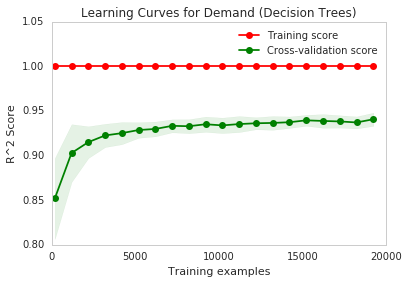

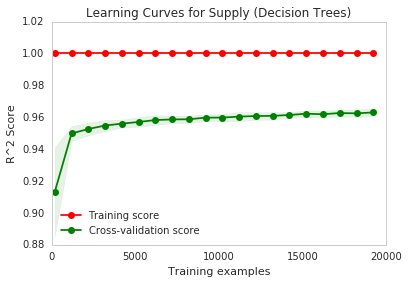


Training Demand Forecaster Decision Trees

Train Size: 4000 Train Score: 1.0 Test Score: 0.876039468367
Train Size: 8000 Train Score: 0.999999567477 Test Score: 0.805632820758
Train Size: 12000 Train Score: 0.999999760205 Test Score: 0.902722020332
Train Size: 16000 Train Score: 0.999999789114 Test Score: 0.900074896024
Train Size: 20000 Train Score: 0.999999880792 Test Score: 0.928977338555
Train Size: 24024 Train Score: 0.999999870448 Test Score: 0.92830186529

Training Supply Forecaster Decision Trees

Train Size: 4000 Train Score: 1.0 Test Score: 0.918885489579
Train Size: 8000 Train Score: 0.999999753397 Test Score: 0.909536393854
Train Size: 12000 Train Score: 0.999999860582 Test Score: 0.958602983955
Train Size: 16000 Train Score: 0.999999877059 Test Score: 0.956677353051
Train Size: 20000 Train Score: 0.999999837794 Test Score: 0.962463540558
Train Size: 24024 Train Score: 0.999999832259 Test Score: 0.963137166274


In [81]:
from sklearn.tree import DecisionTreeRegressor

# Decision Trees only supports MSE score for deciding splits
generate_learningcurves(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                        r_alg=DecisionTreeRegressor(), a_alg=DecisionTreeRegressor(), alg_name="Decision Trees")

generate_traintestscores(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                         rX_test=rX_test, ry_test=ry_test, aX_test=aX_test, ay_test=ay_test,
                         r_alg=DecisionTreeRegressor(), a_alg=DecisionTreeRegressor(), alg_name="Decision Trees")

## Hyper Parameter Selection

Best Estimator (Demand):
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=1.0,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')
CV accuracy (Demand): -0.080 +/- 0.086
Best Estimator (Demand):
DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=1.0,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=0,
           splitter='best')
CV accuracy (Demand): -0.048 +/- 0.034


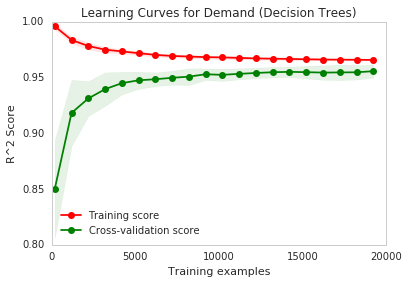

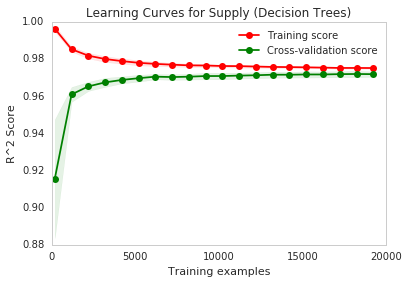


Training Demand Forecaster Decision Trees

Train Size: 4000 Train Score: 0.964717516087 Test Score: 0.90337950646
Train Size: 8000 Train Score: 0.954472937132 Test Score: 0.834093284828
Train Size: 12000 Train Score: 0.959533729804 Test Score: 0.941047872431
Train Size: 16000 Train Score: 0.959142686616 Test Score: 0.940232099723
Train Size: 20000 Train Score: 0.963693587943 Test Score: 0.95180879138
Train Size: 24024 Train Score: 0.964953797387 Test Score: 0.951828985957

Training Supply Forecaster Decision Trees

Train Size: 4000 Train Score: 0.974311637356 Test Score: 0.942263232247
Train Size: 8000 Train Score: 0.963796805095 Test Score: 0.94246171806
Train Size: 12000 Train Score: 0.96645349236 Test Score: 0.967243331095
Train Size: 16000 Train Score: 0.965600443574 Test Score: 0.967368667604
Train Size: 20000 Train Score: 0.973747372447 Test Score: 0.973755025477
Train Size: 24024 Train Score: 0.97470761467 Test Score: 0.973751980662


In [84]:
# Use GridSearchCV - Demand
# Specify parameters
param_grid = {'max_features'      : [0.25, 0.5, 0.75, 1.0],
              'max_depth'         : [5, 10, 15, 20, 25],
              'min_samples_split' : [2, 3, 4, 5, 10],
              'random_state'      : [0]}
             
alg = DecisionTreeRegressor()

select_hyperparams(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                   rX_test=rX_test, ry_test=ry_test, aX_test=aX_test, ay_test=ay_test,
                   alg=alg, param_grid=param_grid, scoring_func='mean_squared_error')

# K NEAREST NEIGHBORS

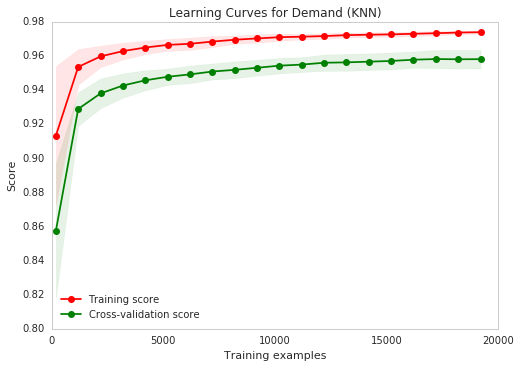

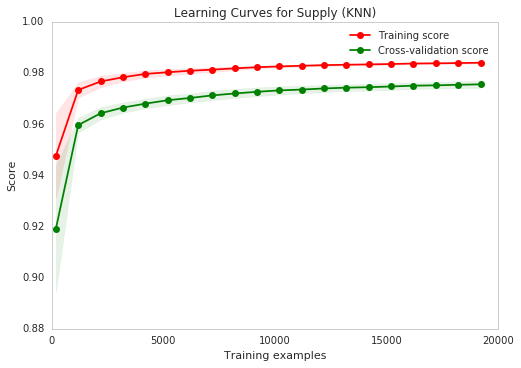


Training Demand Forecaster KNN

Train Size: 4000 Train Score: 0.965864397907 Test Score: 0.911983899096
Train Size: 8000 Train Score: 0.964002044417 Test Score: 0.915596397551
Train Size: 12000 Train Score: 0.967895938952 Test Score: 0.937561345004
Train Size: 16000 Train Score: 0.968553610672 Test Score: 0.93727632459
Train Size: 20000 Train Score: 0.973686789591 Test Score: 0.956880429043
Train Size: 24024 Train Score: 0.974609920594 Test Score: 0.956999290195

Training Supply Forecaster KNN

Train Size: 4000 Train Score: 0.981906883062 Test Score: 0.928810954826
Train Size: 8000 Train Score: 0.975603364958 Test Score: 0.935986619373
Train Size: 12000 Train Score: 0.97862630611 Test Score: 0.969522496256
Train Size: 16000 Train Score: 0.978278314141 Test Score: 0.969727478259
Train Size: 20000 Train Score: 0.983936199419 Test Score: 0.974706523843
Train Size: 24024 Train Score: 0.98452608949 Test Score: 0.974856104756


In [49]:
from sklearn.neighbors import KNeighborsRegressor

# KNN defaults to R^2 score
generate_learningcurves(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                        alg_func=KNeighborsRegressor(), alg_name="KNN")

generate_traintestscores(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                         rX_test=rX_test, ry_test=ry_test, aX_test=aX_test, ay_test=ay_test,
                         alg_func=KNeighborsRegressor(), alg_name="KNN")

# SUPPORT VECTOR MACHINES

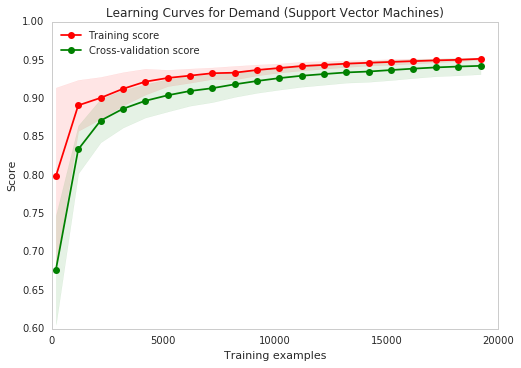

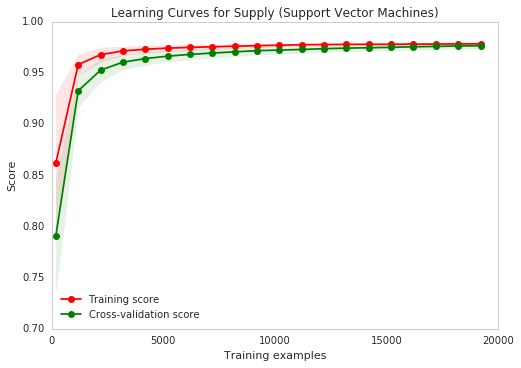


Training Demand Forecaster Support Vector Machines

Train Size: 4000 Train Score: 0.959360863952 Test Score: 0.792282857092
Train Size: 8000 Train Score: 0.954530845335 Test Score: 0.784144643536
Train Size: 12000 Train Score: 0.946497439926 Test Score: 0.824313068215
Train Size: 16000 Train Score: 0.948104346774 Test Score: 0.821808071389
Train Size: 20000 Train Score: 0.953904480576 Test Score: 0.900586107935
Train Size: 24024 Train Score: 0.955018231687 Test Score: 0.900256570829

Training Supply Forecaster Support Vector Machines

Train Size: 4000 Train Score: 0.977924189958 Test Score: 0.824612069706
Train Size: 8000 Train Score: 0.969370859908 Test Score: 0.817922069734
Train Size: 12000 Train Score: 0.972303219181 Test Score: 0.922420876354
Train Size: 16000 Train Score: 0.97196122751 Test Score: 0.920985429705
Train Size: 20000 Train Score: 0.978294710274 Test Score: 0.974912700958
Train Size: 24024 Train Score: 0.978948329844 Test Score: 0.975409880649


In [47]:
from sklearn.svm import SVR

# Linear Regression defaults to R^2 score
generate_learningcurves(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                        alg_func=SVR(), alg_name="Support Vector Machines")

generate_traintestscores(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                         rX_test=rX_test, ry_test=ry_test, aX_test=aX_test, ay_test=ay_test,
                         alg_func=SVR(), alg_name="Support Vector Machines")

# LINEAR REGRESSION

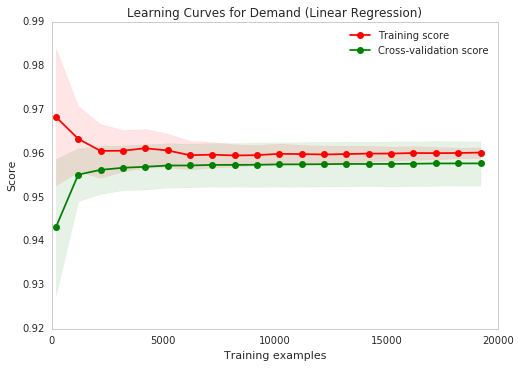

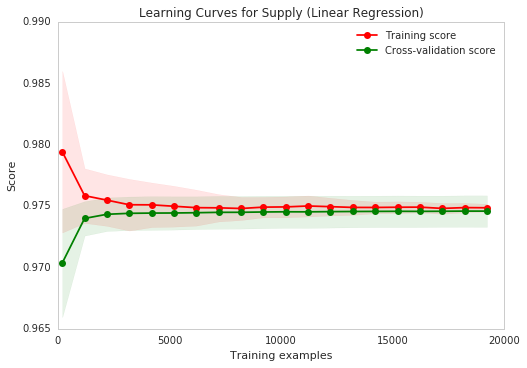


Training Demand Forecaster Linear Regression

Train Size: 4000 Train Score: 0.951067016421 Test Score: 0.96687058269
Train Size: 8000 Train Score: 0.945311587547 Test Score: 0.965808266064
Train Size: 12000 Train Score: 0.948376770724 Test Score: 0.965115872519
Train Size: 16000 Train Score: 0.949799060991 Test Score: 0.965549883742
Train Size: 20000 Train Score: 0.958453096718 Test Score: 0.965485185387
Train Size: 24024 Train Score: 0.959755456836 Test Score: 0.965546371127

Training Supply Forecaster Linear Regression

Train Size: 4000 Train Score: 0.96960013005 Test Score: 0.979130178555
Train Size: 8000 Train Score: 0.959423988936 Test Score: 0.979067759751
Train Size: 12000 Train Score: 0.964145312357 Test Score: 0.979224167246
Train Size: 16000 Train Score: 0.964291311531 Test Score: 0.979316123053
Train Size: 20000 Train Score: 0.973906565307 Test Score: 0.979352186172
Train Size: 24024 Train Score: 0.9748194508 Test Score: 0.979365861204


In [31]:
from sklearn.linear_model import LinearRegression

# Linear Regression defaults to R^2 score
generate_learningcurves(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                        alg_func=LinearRegression(), alg_name="Linear Regression")

generate_traintestscores(rX_train=rX_train, ry_train=ry_train, aX_train=aX_train, ay_train=ay_train,
                         rX_test=rX_test, ry_test=ry_test, aX_test=aX_test, ay_test=ay_test,
                         alg_func=LinearRegression(), alg_name="Linear Regression")

# BENCHMARK - SIMPLE AVERAGE

In [17]:
# Return simple average of previous 3 time slots
def simple_average(df, t1, t2, t3):
    return df.apply(lambda r: ((r[t1] + r[t2] + r[t3]) / 3.0), axis=1)

# Define list of predictors for demand, supply
r_predictors = ['district_id', 'num_day', 'time_slot', 'demand_t-1', 'demand_t-2', 'demand_t-3'] 
a_predictors = ['district_id', 'num_day', 'time_slot', 'supply_t-1', 'supply_t-2', 'supply_t-3']

# Set arguments for gap forecasting function
kwargs = {"train_set": X_train, "validate_set": X_validate, "test_set": X_test, 
          "demand_predictors": r_predictors, "supply_predictors": a_predictors,
          "rfit_func": simple_average, "rfit_args": ['demand_t-1','demand_t-2','demand_t-3'],
          "afit_func": simple_average, "afit_args": ['supply_t-1','supply_t-2','supply_t-3']}

gap_forecast(**kwargs)



DEMAND FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	784.82		0.93		3.24
VALIDATE  	1055.78		0.94		0.66
TEST      	888.39		0.94		0.69


SUPPLY FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	252.86		0.96		2.90
VALIDATE  	262.72		0.97		0.60
TEST      	241.56		0.97		0.63


GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	508.04		0.59		4.40
VALIDATE  	776.12		0.77		0.98
TEST      	639.48		0.77		0.89
